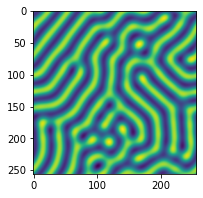

In [1]:
import scipy.io as sio
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments')
from myPDEFIND import *
#sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/numerics')
#import convection_patterns_v2 as cp

#cp.solveSH(20*np.pi,20*np.pi,256,256,.1,100,"SHAutoEncode_3",Rscale=.5,
#            beta=.45,amplitude=.1,init_flag=1,energy=False)
data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/SHAutoEncode_3.mat")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.imshow(data['uu'][500,:,:])

Load data

In [2]:
tt = data['tt'][0][1:] #TVALUES, EXCLUDING FIRST ONE
xx = data['xx']
yy = data['yy']
U = data['uu'][1:1001,:,:] #TAKE LAST 1000 U surfaces
dt = data['tt'][0][1]-data['tt'][0][0]
Ut = BackwardDiff(U,data['uu'][0:1000,:,:],dt) #Compute U derivatives
n_samples = len(tt)
N = len(xx)*len(yy)
perm = np.random.permutation(int(.9*n_samples))
training_samples = perm[:int(.8*n_samples)]
val_samples = perm[int(.8*n_samples):]
test_samples = np.arange(int(.9*n_samples), n_samples)

#subsampling by factor of 2
training_data = {'tt': tt[training_samples],
                     'xx': xx[::2].T,
                     'yy': yy[::2].T,
                     'U': U[training_samples,::2,::2],
                     'Ut': Ut[training_samples,::2,::2]}
val_data = {'tt': tt[val_samples],
                'xx': xx[::2].T,
                'yy': yy[::2].T,
                'U': U[val_samples,::2,::2],
                'Ut': Ut[val_samples,::2,::2]}
test_data = {'tt': tt[test_samples],
                 'xx': xx[::2].T,
                 'yy': yy[::2].T,
                 'U': U[test_samples,::2,::2],
                 'Ut': Ut[test_samples,::2,::2]}


Split data into train and test

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [4]:
u_train = training_data['U']
u_test = test_data['U']
u_val = val_data['U']
u_train = u_train.astype('float32')
u_test = u_test.astype('float32')
u_val = u_val.astype('float32')
print(u_train.shape)
print(u_test.shape)
print(u_val.shape)

(800, 128, 128)
(100, 128, 128)
(100, 128, 128)


In [5]:
# want to make latent space 16 x 16
# our subsampled grids are 64 x 64
latent_dim = 1024

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation='linear'),
      layers.Dense(512, activation='sigmoid'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(2048, activation='linear'),
      layers.Dense(4096, activation='sigmoid'),
      layers.Dense(8192, activation='relu'),
      layers.Dense(16384, activation='linear'),
      layers.Reshape((128, 128))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

2022-11-28 14:19:29.089613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(u_train, u_train,
                epochs=10,
                shuffle=True,
                validation_data=(u_test, u_test))

Epoch 1/10
25/25 [==============================] - 50s 2s/step - loss: 0.1346 - val_loss: 0.0489
Epoch 2/10
25/25 [==============================] - 40s 2s/step - loss: 0.0616 - val_loss: 0.0368
Epoch 3/10
25/25 [==============================] - 37s 1s/step - loss: 0.0613 - val_loss: 0.0690
Epoch 4/10
25/25 [==============================] - 31s 1s/step - loss: 0.0601 - val_loss: 0.0498
Epoch 5/10
25/25 [==============================] - 34s 1s/step - loss: 0.0585 - val_loss: 0.0490
Epoch 6/10
25/25 [==============================] - 46s 2s/step - loss: 0.0580 - val_loss: 0.0582
Epoch 7/10
25/25 [==============================] - 54s 2s/step - loss: 0.0591 - val_loss: 0.0635
Epoch 8/10
25/25 [==============================] - 68s 3s/step - loss: 0.0596 - val_loss: 0.0636
Epoch 9/10
25/25 [==============================] - 36s 1s/step - loss: 0.0585 - val_loss: 0.0608
Epoch 10/10
25/25 [==============================] - 41s 1s/step - loss: 0.0589 - val_loss: 0.0571


In [7]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
Total params: 4,851,456
Trainable params: 4,851,456
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)        

In [8]:
encoded_data = autoencoder.encoder(u_val).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

time step:  23
time step:  1
time step:  42
time step:  8
time step:  32
time step:  26
time step:  51
time step:  70
time step:  38
time step:  28


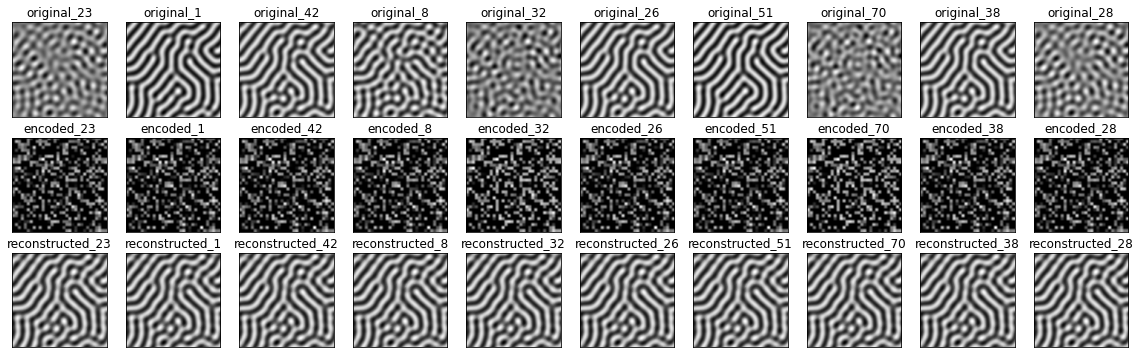

In [9]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  idx = np.random.randint(1,99)
  print("time step: ",idx)
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(u_val[idx])
  plt.title("original"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reshaped encoded
  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(encoded_data[idx].reshape(32,32))
  plt.title("encoded"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(decoded_data[idx])
  plt.title("reconstructed"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig("/Users/edwardmcdugald/Research/convection_patterns_wip/figs/writeup/ae5.png")

In [10]:
conv_u_train = u_train[..., tf.newaxis]
conv_u_test = u_test[..., tf.newaxis]
conv_u_val = u_val[..., tf.newaxis]
print(conv_u_train.shape)
print(conv_u_test.shape)
print(conv_u_val.shape)

(800, 128, 128, 1)
(100, 128, 128, 1)
(100, 128, 128, 1)


In [11]:
class ConvAutoencoder(Model):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(128, 128,1)),
      layers.Conv2D(16, (3, 3), activation='linear', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='sigmoid', padding='same', strides=2),
      layers.Conv2D(1, (3, 3), activation='relu', padding='same')])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='sigmoid', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Dense(100,activation='relu'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='linear', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

conv_autoencoder = ConvAutoencoder()


In [12]:
conv_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
conv_autoencoder.fit(conv_u_train, conv_u_train,
                epochs=10,
                shuffle=True,
                validation_data=(conv_u_test, conv_u_test))

Epoch 1/10
25/25 [==============================] - 27s 1s/step - loss: 0.2263 - val_loss: 0.3110
Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 0.2183 - val_loss: 0.2666
Epoch 3/10
25/25 [==============================] - 26s 1s/step - loss: 0.1322 - val_loss: 0.0944
Epoch 4/10
25/25 [==============================] - 26s 1s/step - loss: 0.0762 - val_loss: 0.0713
Epoch 5/10
25/25 [==============================] - 25s 1s/step - loss: 0.0626 - val_loss: 0.0602
Epoch 6/10
25/25 [==============================] - 25s 1s/step - loss: 0.0543 - val_loss: 0.0521
Epoch 7/10
25/25 [==============================] - 26s 1s/step - loss: 0.0481 - val_loss: 0.0463
Epoch 8/10
25/25 [==============================] - 25s 1s/step - loss: 0.0433 - val_loss: 0.0414
Epoch 9/10
25/25 [==============================] - 26s 1s/step - loss: 0.0396 - val_loss: 0.0380
Epoch 10/10
25/25 [==============================] - 27s 1s/step - loss: 0.0366 - val_loss: 0.0350


In [13]:
conv_autoencoder.encoder.summary()
conv_autoencoder.decoder.summary()
conv_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 1)         73        
                                                                 
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 32, 32, 1)        10        
 nspose)                                                         
                              

In [14]:
conv_encoded_data = autoencoder.encoder(conv_u_val).numpy()
conv_decoded_data = autoencoder.decoder(conv_encoded_data).numpy()
np.shape(conv_encoded_data)

(100, 1024)

time step:  41
time step:  25
time step:  96
time step:  4
time step:  89
time step:  16
time step:  49
time step:  17
time step:  90
time step:  9


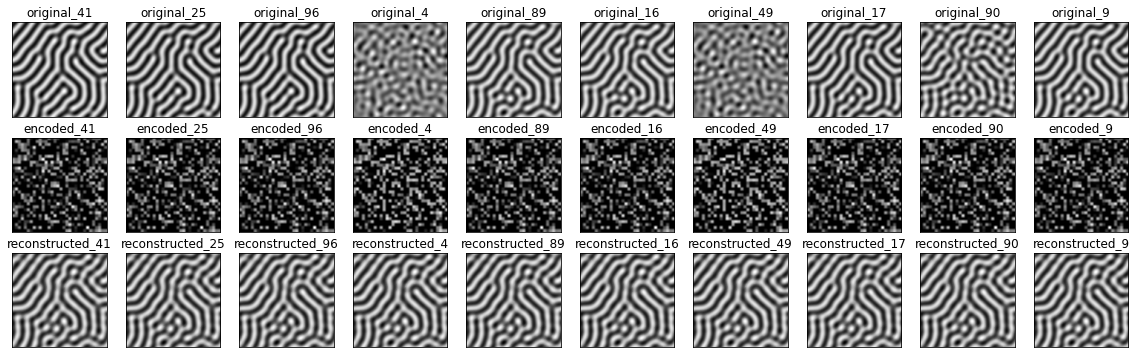

In [15]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
  idx = np.random.randint(1,99)
  print("time step: ",idx)
  # display original
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(tf.squeeze(conv_u_val[i]))
  plt.title("original"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # # display reshaped encoded
  ax = plt.subplot(3, n, i + 1+n)
  plt.imshow(tf.squeeze(conv_encoded_data[i].reshape(32,32)))
  plt.title("encoded"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, i + 1 + 2*n)
  plt.imshow(conv_decoded_data[i])
  plt.title("reconstructed"+"_"+str(idx))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.savefig("/Users/edwardmcdugald/Research/convection_patterns_wip/figs/writeup/ae6.png")

In [16]:
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments')
from myPDEFIND import *
import math

t = data['tt'].T[:,0]
x = data['xx'].T[0,:]
y = data['yy'].T[0,:]
U = data['uu']
print("data shape: ",np.shape(U))

nx = len(x)
ny = len(y)
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]
print("dt=",dt,"dx=",dx,"dy=",dy)

num_t = 20
x_subsample = 8
y_subsample = 8
t_vals = np.arange(1,len(t),math.floor(len(t)/num_t))
x_vals = np.arange(0,nx,x_subsample)
y_vals = np.arange(0,ny,y_subsample)

num_points = num_t*len(x_vals)*len(y_vals)
print("feature vec length: ",num_points)
print(dt)

u = np.zeros((num_points,1))
u_t = np.zeros((num_points,1))
u_x = np.zeros((num_points,1))
u_y = np.zeros((num_points,1))
u_xx = np.zeros((num_points,1))
u_yy = np.zeros((num_points,1))
u_xy = np.zeros((num_points,1))
lapu = np.zeros((num_points,1))
biharmu = np.zeros((num_points,1))


# setting parameters for spectral derivatives
Lx = 2*x[len(x)-1] # Size of enclosing periodic rectangle
Ly = 2*y[len(y)-1]

i=0
for t_idx in t_vals:
    print(t_idx)
    uu = U[t_idx,:,:]
    uu_t = BackwardDiff(U[t_idx,:,:],U[t_idx-1,:,:],dt)
    uu_x = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'x')
    uu_y = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'y')
    uu_xx = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'xx')
    uu_yy = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'yy')
    uu_xy = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'xy')
    lapuu = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'laplacian')
    biharmuu = SpectralDerivs(U[t_idx,:,:],Lx,Ly,'biharmonic')
    for x_idx in x_vals:
        for y_idx in y_vals:
            u[i] = uu[x_idx,y_idx]
            u_t[i] = uu_t[x_idx,y_idx]
            u_x[i] = uu_x[x_idx,y_idx]
            u_y[i] = uu_y[x_idx,y_idx]
            u_xy[i] = uu_xy[x_idx,y_idx]
            lapu[i] = lapuu[x_idx,y_idx]
            biharmu[i] = biharmuu[x_idx,y_idx]
            i+=1

X = np.hstack([np.ones((num_points,1)), u, u**2, u**3,u**4,
                   u_x, u_y, u_x**2, u_y**2, u_x*u_y,u_xy,
               lapu, biharmu])
description = ['','u','u^2','u^3','u^4',
               'u_{x}','u_{y}','u_{x}^2','u_{y}^2','u_{x}u_{y}','u_{xy}'
    ,'lapu','biharmu']

c = TrainSTRidge(X,u_t,10**-5,1)
print_pde(c, description)

data shape:  (1001, 256, 256)
dt= 0.1 dx= 0.24543692606169998 dy= 0.24543692606169998
feature vec length:  20480
0.1
1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
951
u_t = (-0.500644 +0.000000i)u
    + (-1.001568 +0.000000i)u^3
    + (-2.002985 +0.000000i)lapu
    + (-1.001506 +0.000000i)biharmu
   
